## Lesson-06 Recurrent Neural Networks 循环神经网络的原理及应用

循环神经网络是我们常用的一个网络模型，这个网络能够处理例如字符串，时间序列等问题。因为模型对序列问题的优势，RNN模型已经成为了自然语言处理问题的常见方法。

在本课程的作业中，我们将完成三个任务：

0. 基于任务驱动，实际感受并能够初步使用pytorch；
1. 使用RNN模型进行名字的国籍分类；(这个程序主要是参考的Pytorch文档)

RNN也可以用于金融数据的预测，例如:
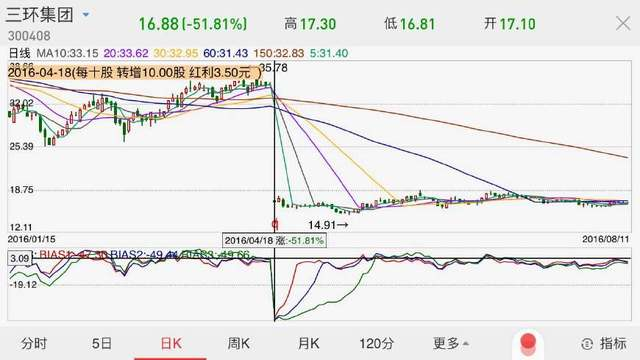

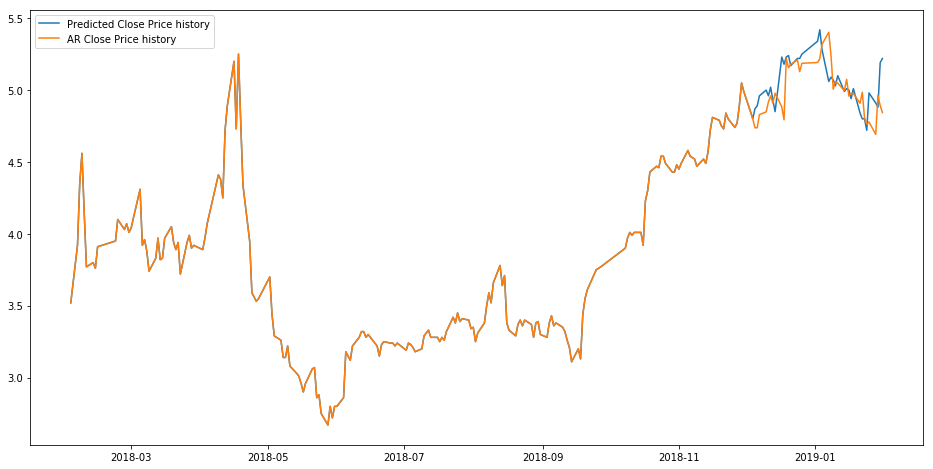

上图中蓝色的部分就是预测值， 关于RNN模型对金融数据的预测，我们只会会增加专门的研讨课程，给大家讲解

我们今天带给大家的是使用RNN进行名字的国籍分类:

## 1. 使用RNN模型进行名字的国籍分类

首先，我们下载数据: 将这个数据置于和我们jupyter notebook位置相同的地方

#### 1.1 我们利用通配符，打印出所有的文件

In [2]:
from io import open
import glob
import os
import matplotlib.pyplot as plt


def find_files(path): return glob.glob(path)

print(find_files('data/names/*.txt'))

['data/names/Czech.txt', 'data/names/German.txt', 'data/names/Arabic.txt', 'data/names/Japanese.txt', 'data/names/Chinese.txt', 'data/names/Vietnamese.txt', 'data/names/Russian.txt', 'data/names/French.txt', 'data/names/Irish.txt', 'data/names/English.txt', 'data/names/Spanish.txt', 'data/names/Greek.txt', 'data/names/Italian.txt', 'data/names/Portuguese.txt', 'data/names/Scottish.txt', 'data/names/Dutch.txt', 'data/names/Korean.txt', 'data/names/Polish.txt']


### 1.2 名字里边包含不少非Ascii码，为了简便问题，我们将他们转化为Ascii码

In [3]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicode_2_Ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicode_2_Ascii('Ślusàrski'))

Slusarski


### Step1.3 然后我们建立类别和对于的名字的dictionary对应

In [4]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def read_lines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicode_2_Ascii(line) for line in lines]

for filename in find_files('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = read_lines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [5]:
n_categories

18

In [6]:
category_lines['Chinese'][:10]

['Ang', 'AuYong', 'Bai', 'Ban', 'Bao', 'Bei', 'Bian', 'Bui', 'Cai', 'Cao']

### 1.4 这一次我们使用pytorch, 来进行向量化

In [7]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letter_to_index(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letter_to_tensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letter_to_index(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letter_to_index(letter)] = 1
    return tensor

print(letter_to_index('J'))

print(line_to_tensor('Jones').size())

35
torch.Size([5, 1, 57])


In [8]:
line_to_tensor('Jones')

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0

我们可以看到，是对名字里的每个字符做了 one-hot操作

### 1.5 然后，我们构建一个这样的RNN网络

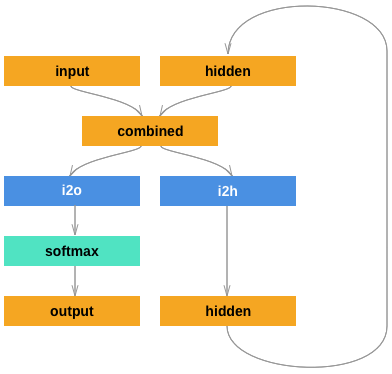

In [9]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128

In [11]:
rnn = RNN(n_letters, n_hidden, n_categories)
rnn

RNN(
  (i2h): Linear(in_features=185, out_features=128, bias=True)
  (i2o): Linear(in_features=185, out_features=18, bias=True)
  (softmax): LogSoftmax()
)

### 1.6 运行一步RNN

为了运行这个rnn网络，我们需要给他一个input，然后再加上一个hidden state. 然后我们就能过获得一个output，这个output便是的是这个单词的属于每个国家的概率，和接下来的hidden state.

In [12]:
input = letter_to_tensor('A')
hidden =torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [13]:
output

tensor([[-2.8961, -2.9345, -2.9714, -2.7828, -2.8553, -2.9569, -2.8719, -2.9301,
         -2.9205, -2.9804, -2.8791, -2.8420, -2.9270, -2.8983, -2.8944, -2.8087,
         -2.7918, -2.9146]], grad_fn=<LogSoftmaxBackward>)

In [14]:
next_hidden

tensor([[-0.0033,  0.0340, -0.1227,  0.1022, -0.0005,  0.0216, -0.0477,  0.1112,
         -0.0534,  0.0717,  0.0470,  0.0750,  0.0874, -0.0097, -0.0170, -0.0971,
         -0.0307,  0.0474, -0.0035,  0.0031,  0.0813,  0.0588,  0.0330, -0.0732,
          0.0525, -0.0017,  0.0200,  0.0162,  0.0983, -0.0921,  0.0821, -0.0510,
          0.0128, -0.0904,  0.1065,  0.0136,  0.0163, -0.0536,  0.0038,  0.0590,
          0.0151, -0.0583, -0.0249, -0.0839,  0.0197,  0.0674, -0.0956,  0.0508,
          0.0507,  0.0187, -0.0384, -0.1150, -0.0294,  0.0224,  0.0111,  0.1402,
          0.0644,  0.0876,  0.0661, -0.0166,  0.0840, -0.1064,  0.0280,  0.1182,
          0.0502, -0.0662,  0.0010,  0.1342,  0.0785,  0.1139, -0.0019,  0.1026,
          0.0084,  0.0921, -0.0104, -0.0431, -0.0487,  0.0009,  0.0617, -0.0510,
          0.0408, -0.0152, -0.0252,  0.0312,  0.0834,  0.0670,  0.0585,  0.0650,
          0.0107, -0.0192, -0.0752,  0.0489,  0.0822,  0.0891, -0.0268, -0.0167,
          0.0609,  0.0064, -

然后，我们可以使用 line_to_tensor, 把一句话直接变成 tensor

In [15]:
input = line_to_tensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8961, -2.9345, -2.9714, -2.7828, -2.8553, -2.9569, -2.8719, -2.9301,
         -2.9205, -2.9804, -2.8791, -2.8420, -2.9270, -2.8983, -2.8944, -2.8087,
         -2.7918, -2.9146]], grad_fn=<LogSoftmaxBackward>)


这个output，就是基于目前的RNN参数，预测出来的国籍概率分布。显然是不对的，因为里边的参数都是随机的。

### 1.7 更好的观察结果

为了能够更好的看到我们的训练结果，我们需要把输出的tensor变成我们能看懂的国籍

In [16]:
def category_from_output(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i



对于刚刚产生的output，我们使用这个函数

In [17]:
print(category_from_output(output))

('Japanese', 3)


### 1.8 随机生成训练数据

In [18]:
import random

def sample(l):
    return l[random.randint(0, len(l) - 1)]

def sample_trainning():
    category = sample(all_categories)
    line = sample(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = sample_trainning()
    print('category =', category, '/ line =', line)

category = Italian / line = Bellini
category = French / line = Gagnon
category = Polish / line = Kumiega
category = Korean / line = Chun
category = Portuguese / line = Santos
category = Czech / line = Molcan
category = Spanish / line = Cuevas
category = Portuguese / line = Serafim
category = Czech / line = Matejka
category = Portuguese / line = Machado


### 因为我们这个模型需要 softmax 来获得每个类别，所以我们使用cross-entropy作为Loss函数

In [19]:
criterion = nn.CrossEntropyLoss()

In [20]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [22]:
import time
import math

n_iters = 100000 
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = sample_trainning()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 9s) 2.7955 Silveira / Japanese ✗ (Portuguese)
10000 10% (0m 17s) 2.2711 Alves / Dutch ✗ (Portuguese)
15000 15% (0m 25s) 2.5555 Cormac / Scottish ✗ (Irish)
20000 20% (0m 34s) 1.2814 Suh / Vietnamese ✗ (Korean)
25000 25% (0m 44s) 2.3813 Ceallach / Scottish ✗ (Irish)
30000 30% (0m 54s) 0.2720 Dubanowski / Polish ✓
35000 35% (1m 4s) 2.6096 Diaz / Vietnamese ✗ (Spanish)
40000 40% (1m 13s) 2.2105 Hassel / Polish ✗ (Dutch)
45000 45% (1m 26s) 1.2319 Sortras / Greek ✓
50000 50% (1m 37s) 1.3023 Auberton / English ✓
55000 55% (1m 47s) 0.2886 Metrofanis / Greek ✓
60000 60% (1m 56s) 0.3109 Dam / Vietnamese ✓
65000 65% (2m 6s) 1.2155 Ventura / Portuguese ✗ (Spanish)
70000 70% (2m 15s) 1.6093 Eglin / Scottish ✗ (English)
75000 75% (2m 23s) 3.9494 Linart / French ✗ (Czech)
80000 80% (2m 31s) 7.5238 Comino / Italian ✗ (Greek)
85000 85% (2m 39s) 0.2349 Agteren / Dutch ✓
90000 90% (2m 47s) 1.9839 Samuel / Arabic ✗ (French)
95000 95% (2m 56s) 1.6590 Cummins / English ✓
100000 100% (3m 4s) 1.29

### 1.9 观察Loss的变化

In [23]:
all_losses[0:10]

[2.8426823287010192,
 2.7782042815685273,
 2.683708249390125,
 2.5510083508342505,
 2.4371517238914966,
 2.403721686065197,
 2.334552015721798,
 2.236017679288983,
 2.2211326795220376,
 2.204250138282776]

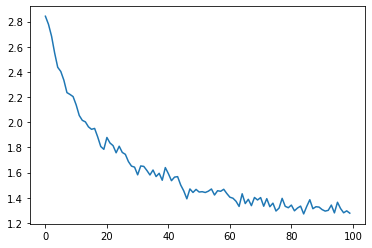

In [25]:
import matplotlib.pyplot as plt
plt.plot(all_losses)

In [26]:
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(line_to_tensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.26) Russian
(-1.85) Czech
(-3.58) English

> Jackson
(-0.54) Scottish
(-1.80) English
(-2.00) Russian

> Satoshi
(-0.80) Italian
(-1.57) Japanese
(-2.60) Polish


In [27]:
similarity = torch.zeros(n_categories, n_categories)

for i in range(n_iters):
    category, line, category_tensor, line_tensor = sample_trainning()
    output, loss = train(category_tensor, line_tensor)
    guess, guess_i = category_from_output(output)
    category_i = all_categories.index(category)
    similarity[category_i][guess_i] += 1
    
for i in  range(n_categories):
    similarity[i] = similarity[i] / similarity[i].sum()

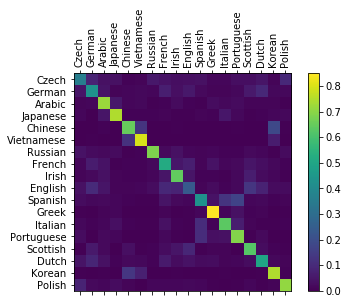

In [28]:
# plot similarity
import numpy as np
import matplotlib.ticker as ticker

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(np.array(similarity))#.numpy())
fig.colorbar(cax)

ax.set_xticklabels([''] + all_categories, rotation = 90)
ax.set_yticklabels([''] + all_categories)

# force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

pltt.show() # seems very good for seperation.

## 代码练习

### 1. 尝试在我们的RNN模型中添加更多layers，然后观察Loss变化

In [29]:
import torch.nn as nn

class mRNN(nn.Module):
    def __init__(self, input_size, hidden_size, layer_size, output_size):
        super(mRNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.layer_size = layer_size
        
        self.rnn = nn.RNN(input_size, hidden_size, layer_size, batch_first=False, nonlinearity='tanh')
        self.linear = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim = 1)
        
    def forward(self, input, hidden):
        h0 = torch.zeros(self.layer_size, 1, self.hidden_size).requires_grad_()
        output, hidden = self.rnn(input, h0)#.detach())
        
        output = self.linear(output[:, -1, :])
        hidden = self.linear(hidden[:, -1, :])
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(self.layer_size, 1, self.hidden_size).requires_grad_()
    
n_hidden = 128
layer_size = 3 # set 3 hidden layers
model = mRNN(n_letters, n_hidden, layer_size, n_categories)
print(model)

mRNN(
  (rnn): RNN(57, 128, num_layers=3)
  (linear): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax()
)


In [30]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train_multiLayers(category_tensor, line_tensor):
    hidden = model.initHidden()

    model.zero_grad() # set weights to 0

    for i in range(line_tensor.size()[0]):
        output, hidden = model(line_tensor[i].expand(1,1,57), hidden)
    
    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in model.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [32]:
n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = sample_trainning()
#     print(category_tensor)
    output, loss = train_multiLayers(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0


5000 5% (19m 32s) 2.0186 Mustafa / Czech ✗ (Arabic)
10000 10% (19m 54s) 1.9047 Esteves / Greek ✗ (Portuguese)
15000 15% (20m 16s) 2.0833 Ryu / Vietnamese ✗ (Korean)
20000 20% (20m 37s) 2.1900 Sabbagh / Vietnamese ✗ (Arabic)
25000 25% (20m 58s) 1.5413 Davy / Irish ✗ (English)
30000 30% (21m 19s) 2.3034 Sevriens / Greek ✗ (Dutch)
35000 35% (21m 40s) 2.7349 Dojin / Irish ✗ (Russian)
40000 40% (22m 1s) 2.2421 Malone / French ✗ (English)
45000 45% (22m 22s) 1.4737 Gorski / Polish ✓
50000 50% (22m 43s) 2.2575 Merckx / French ✗ (Dutch)
55000 55% (23m 4s) 1.2698 Kawasawa / Japanese ✓
60000 60% (23m 25s) 1.7377 Kessel / Czech ✓
65000 65% (23m 46s) 1.4798 Schumacher / German ✓
70000 70% (24m 7s) 1.9923 Belrose / French ✓
75000 75% (24m 28s) 1.1470 Starek / Czech ✗ (Polish)
80000 80% (24m 50s) 1.8553 Mckay / Irish ✗ (Scottish)
85000 85% (25m 12s) 0.9674 Geng / Chinese ✓
90000 90% (25m 33s) 3.0371 Han / Irish ✗ (Vietnamese)
95000 95% (25m 54s) 2.2861 Smets / Greek ✗ (Dutch)
100000 100% (26m 16s) 2

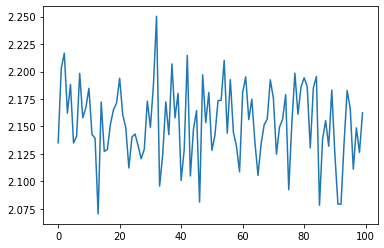

In [33]:
plt.plot(all_losses)

### 2. 将原始的RNN模型改成nn.LSTM和nn.GRU， 并且改变 `n_iters = 1000 ` 这个值，观察其变化

#### LSTM

In [34]:
#### LSTM
class LSTM_RNN(nn.Module):
    def __init__(self, input_size, hidden_size, layer_size, output_size):
        super(LSTM_RNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.layer_size = layer_size
        
        self.lstm = nn.LSTM(input_size, hidden_size, layer_size, batch_first=False)
        self.linear = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim = 1)
        
    def forward(self, input):
        h0 = torch.zeros(self.layer_size, 1, self.hidden_size).requires_grad_()
        c0 = torch.zeros(self.layer_size, 1, self.hidden_size).requires_grad_()
    
        output, (hidden, cell) = self.lstm(input, (h0, c0))#.detach())
        
        output = self.linear(output[:, -1, :])
        output = self.softmax(output)
        return output
    
    def initHidden(self):
        return torch.zeros(self.layer_size, 1, self.hidden_size).requires_grad_()
    
n_hidden = 128
n_layer = 3 # set 3 hidden layers
LSTM = LSTM_RNN(n_letters, n_hidden, n_layer, n_categories)
LSTM

LSTM_RNN(
  (lstm): LSTM(57, 128, num_layers=3)
  (linear): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax()
)

In [35]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train_LSTM(category_tensor, line_tensor):
    hidden = LSTM.initHidden()
    
    LSTM.zero_grad()

    for i in range(line_tensor.size()[0]):
        output = LSTM(line_tensor[i].expand(1,1,57))
    
    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in LSTM.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [37]:
n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = sample_trainning()
    output, loss = train_LSTM(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0


5000 5% (47m 19s) 2.9341 Fulton / Arabic ✗ (English)
10000 10% (47m 54s) 2.7993 Lieu / Vietnamese ✓
15000 15% (48m 29s) 2.8993 Solberg / English ✗ (German)
20000 20% (49m 5s) 2.8978 Santiago / Polish ✗ (Portuguese)
25000 25% (49m 39s) 2.8898 Ba / French ✗ (Arabic)
30000 30% (50m 13s) 2.8885 Whyte / French ✗ (Scottish)
35000 35% (50m 47s) 2.8726 Elizondo / Vietnamese ✗ (Spanish)
40000 40% (51m 22s) 2.8881 Fleming / Polish ✗ (Scottish)
45000 45% (51m 56s) 2.8812 Velazquez / Czech ✗ (Spanish)
50000 50% (52m 30s) 2.8603 D arcy / Greek ✗ (English)
55000 55% (53m 11s) 2.8201 Almasi / Korean ✗ (Arabic)
60000 60% (53m 50s) 2.8621 Papoutsis / Czech ✗ (Greek)
65000 65% (54m 28s) 2.8970 Ciardha / English ✗ (Irish)
70000 70% (55m 8s) 2.8435 Dickson / Korean ✗ (Scottish)
75000 75% (55m 46s) 2.9220 Rome / Dutch ✗ (French)
80000 80% (56m 25s) 2.9350 Fernandes / German ✗ (Portuguese)
85000 85% (57m 3s) 2.8316 Strilakos / French ✗ (Greek)
90000 90% (57m 42s) 2.8474 Plourde / Dutch ✗ (French)
95000 95% 

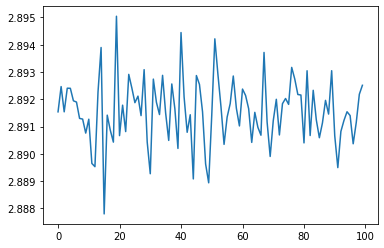

In [38]:
plt.plot(all_losses)

#### GRU

In [39]:
#### GRU
class GRU_RNN(nn.Module):
    def __init__(self, input_size, hidden_size, layer_size, output_size):
        super(GRU_RNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.layer_size = layer_size
        
        self.gru = nn.GRU(input_size, hidden_size, layer_size, batch_first=False)
        self.linear = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim = 1)
        
    def forward(self, input):
        h0 = torch.zeros(self.layer_size, 1, self.hidden_size).requires_grad_()

        output, hidden = self.gru(input, h0)#.detach())
        
        output = self.linear(output[:, -1, :])

        output = self.softmax(output)
        return output
    
    def initHidden(self):
        return torch.zeros(self.layer_size, 1, self.hidden_size).requires_grad_()
     
n_hidden = 128
n_layer = 3 # set 3 hidden layers
GRU = GRU_RNN(n_letters, n_hidden, n_layer, n_categories)
GRU

GRU_RNN(
  (gru): GRU(57, 128, num_layers=3)
  (linear): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax()
)

In [40]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn
# optimizer = torch.optim.SGD(GRU.parameters(), lr=learning_rate)

def train_GRU(category_tensor, line_tensor):
    hidden = GRU.initHidden()
    
    GRU.zero_grad()

    for i in range(line_tensor.size()[0]):
        output = GRU(line_tensor[i].expand(1,1,57))

    loss = criterion(output, category_tensor)
    loss.backward()
#     optimizer.step()
    # Add parameters' gradients to their values, multiplied by learning rate
    for p in GRU.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [41]:
n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = sample_trainning()
    output, loss = train_GRU(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0


5000 5% (62m 26s) 2.9513 Loritz / Spanish ✗ (German)
10000 10% (63m 2s) 2.7877 Bahar / Irish ✗ (Arabic)
15000 15% (63m 38s) 2.9715 Furst / English ✗ (German)
20000 20% (64m 14s) 2.8037 Morris / Arabic ✗ (English)
25000 25% (64m 51s) 2.8614 Tableriou / Spanish ✗ (Greek)
30000 30% (65m 27s) 2.8649 Slivka / Polish ✗ (Czech)
35000 35% (66m 4s) 2.7630 Kotsiopoulos / Greek ✓
40000 40% (66m 39s) 2.8590 Quigley / Korean ✗ (Irish)
45000 45% (67m 15s) 2.9113 Clark / Italian ✗ (Scottish)
50000 50% (67m 51s) 2.9228 Shiomiya / Czech ✗ (Japanese)
55000 55% (68m 26s) 2.9128 Mckay / Scottish ✗ (Irish)
60000 60% (69m 2s) 2.8345 Borovski / Chinese ✗ (Czech)
65000 65% (69m 43s) 2.8854 Hadad / Scottish ✗ (Arabic)
70000 70% (70m 32s) 2.5081 Zhong / Irish ✗ (Chinese)
75000 75% (71m 13s) 2.7403 Romijn / Scottish ✗ (Dutch)
80000 80% (72m 0s) 2.4980 Sarraf / Arabic ✓
85000 85% (72m 37s) 2.3633 Sarraf / Arabic ✓
90000 90% (73m 16s) 2.3352 Goulden / Irish ✗ (English)
95000 95% (73m 58s) 2.4412 Gage / Dutch ✗ (Fr

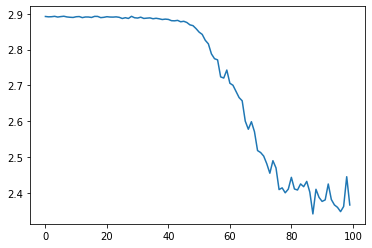

In [42]:
plt.plot(all_losses)

### 3. 把该RNN模型变成多层RNN模型，观察Loss的变化

> todo

### 4. Pytorch里边常用nn.NLLoss来代替crossentropy，将criterion改为nn.NLLoss，观察变化

In [43]:
criterion = nn.NLLLoss()

In [44]:
learning_rate = 0.005

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    
    rnn.zero_grad()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
#     print(output)
#     print(category_tensor)
    loss = criterion(output, category_tensor)
    loss.backward()
    
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)
        
    return output, loss.item()

In [45]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# keep track of loss for ploting
current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = sample_trainning()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    # Print iter number, loss, name, and guess
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))
        #µ≤≥÷…¬˚˚∆∆˙©
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 9s) 3.2094 Zilberschlag / Spanish ✗ (German)
10000 10% (0m 17s) 2.9714 Alber / Arabic ✗ (English)
15000 15% (0m 26s) 0.2191 Mclean / Scottish ✓
20000 20% (0m 36s) 0.5205 Agteren / Dutch ✓
25000 25% (0m 51s) 0.0574 Kozlow / Polish ✓
30000 30% (1m 3s) 0.6865 Luu / Vietnamese ✓
35000 35% (1m 11s) 0.3193 Landi / Italian ✓
40000 40% (1m 20s) 0.3499 Delgado / Spanish ✓
45000 45% (1m 30s) 1.1202 Pang / Vietnamese ✗ (Chinese)
50000 50% (1m 39s) 1.0378 Mahoney / Irish ✓
55000 55% (1m 47s) 1.7233 Salazar / Czech ✗ (Spanish)
60000 60% (1m 57s) 0.2070 Jian / Chinese ✓
65000 65% (2m 5s) 1.0015 Marquering / Dutch ✓
70000 70% (2m 14s) 0.7789 Upton / English ✓
75000 75% (2m 24s) 0.4189 Ferro / Portuguese ✓
80000 80% (2m 33s) 0.0289 Tsahalis / Greek ✓
85000 85% (2m 42s) 0.0497 Hakimov / Russian ✓
90000 90% (2m 50s) 0.1157 Majewski / Polish ✓
95000 95% (3m 0s) 0.1352 Wawrzaszek / Polish ✓
100000 100% (3m 9s) 0.0077 Kawaguchi / Japanese ✓


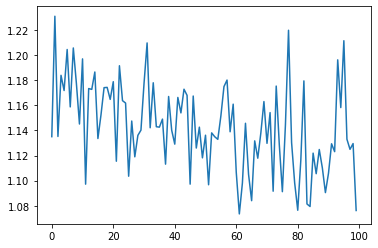

In [46]:
plt.plot(all_losses)

### Summary

It seems that the raw single hidden layer RNN has the lowest loss and best performance. While the losses of multiple hidden layers RNN of LSTM don't decend with training and that of GRU decend at a small degree, this may be due to inaccurate parameters setting. At last, the nn.NLLLoss can generate lower losses than that from nn.CrossEntropy.